# Machine Learning Assignment 2 - Classification Model Implementation

## STUDENT INFORMATION
* **BITS ID:** 2025AB05236
* **Name:** FOUZAN ASHRAF
* **Email:** 2025ab05236@wilp.bits-pilani.ac.in
* **Date:** 14-02-2026
* **Program:** M.Tech AI & ML (BITS Pilani)
* **Semester:** 1st

In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score, 
                             recall_score, f1_score, matthews_corrcoef)

In [2]:
# Model Imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading & Preprocessing

I have considered "Breast Cancer Wisconsin (Diagnostic)" dataset from Kaggle

In [3]:
# Load the dataset from local CSV
# Ensure 'data.csv' is in the same folder as this notebook
df = pd.read_csv('data.csv')

In [4]:
# --- Dataset Details & Source Information ---
print("=" * 40)
print("       DATASET INFORMATION")
print("=" * 40)
print("Dataset Name  : Breast Cancer Wisconsin (Diagnostic) Dataset")
print("Source        : Kaggle")
print("Dataset Link  : https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data")
print("-" * 40)
print(f"Original Shape: {df.shape}")
print(f"Total Samples : {df.shape[0]}")
print(f"Total Features: {df.shape[1]}")
print("-" * 40)
print("Target Variable: 'diagnosis' (M = Malignant, B = Benign)")
print("=" * 40)

       DATASET INFORMATION
Dataset Name  : Breast Cancer Wisconsin (Diagnostic) Dataset
Source        : Kaggle
Dataset Link  : https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data
----------------------------------------
Original Shape: (569, 33)
Total Samples : 569
Total Features: 33
----------------------------------------
Target Variable: 'diagnosis' (M = Malignant, B = Benign)


In [5]:
# --- Display Original Data Shape ---
print("Original Dataset Shape:", df.shape)
print(f"Number of Rows (Instances): {df.shape[0]}")
print(f"Number of Columns (Features): {df.shape[1]}")

# Check for duplicates or missing values
print(f"Missing Values: {df.isnull().sum().sum()}")
print(f"Duplicate Rows: {df.duplicated().sum()}")

Original Dataset Shape: (569, 33)
Number of Rows (Instances): 569
Number of Columns (Features): 33
Missing Values: 569
Duplicate Rows: 0


In [6]:
# Display first few rows
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


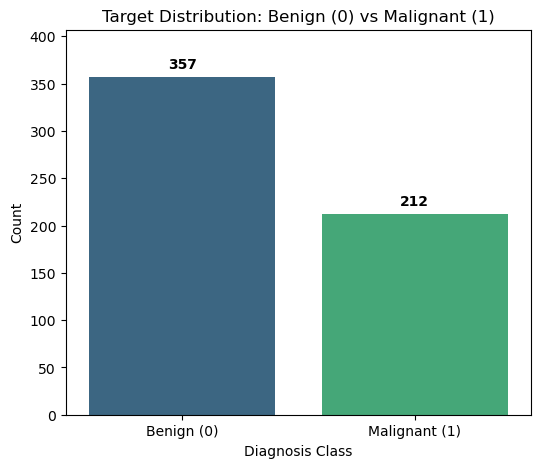

Exact Value Counts:
diagnosis
B (Benign)       357
M (Malignant)    212
Name: count, dtype: int64


In [7]:
# --- Safe Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Assuming df is already defined with a 'diagnosis' column
# First, we need to create and fit the LabelEncoder
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])  # This transforms 'B' and 'M' to 0 and 1

plt.figure(figsize=(6, 5))

# Plot the count plot
ax = sns.countplot(x='diagnosis', data=df, palette='viridis')

# --- DYNAMIC LABELING (Fixes the mismatch risk) ---
# We ask the LabelEncoder (le) to tell us the real names for 0 and 1
label_0 = le.inverse_transform([0])[0]  # Should be 'B'
label_1 = le.inverse_transform([1])[0]  # Should be 'M'

# Map 'B' to 'Benign' and 'M' to 'Malignant' for nicer display
def get_full_name(code):
    if code == 'B': return f"Benign (0)"
    if code == 'M': return f"Malignant (1)"
    return str(code)

ax.set_xticklabels([get_full_name(label_0), get_full_name(label_1)])

# Add Title and Axis Labels
plt.title(f"Target Distribution: {get_full_name(label_0)} vs {get_full_name(label_1)}", fontsize=12)
plt.xlabel("Diagnosis Class")
plt.ylabel("Count")

# Add Exact Counts on Bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontweight='bold')

# Adjust layout to make room for labels
plt.ylim(0, df['diagnosis'].value_counts().max() + 50)
plt.show()

# Verify the exact counts in text form just to be sure
print("Exact Value Counts:")
print(df['diagnosis'].value_counts().rename(index={0: f"{label_0} (Benign)", 1: f"{label_1} (Malignant)"}))

In [8]:
# Basic Preprocessing
# Dropping unnecessary columns (like 'id' or 'Unnamed: 32' often found in this dataset)
if 'id' in df.columns:
    df = df.drop(columns=['id'])
if 'Unnamed: 32' in df.columns:
    df = df.drop(columns=['Unnamed: 32'])

In [9]:
# Encode Target Variable (M/B -> 1/0)
# Assuming target column is 'diagnosis'
target_col = 'diagnosis' 
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])

In [10]:
# Feature Selection
X = df.drop(columns=[target_col])
y = df[target_col]

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (455, 30)
Testing Shape: (114, 30)


# 2. Model Implementation
As required, I have implemented 6 models: Logistic Regression, Decision Tree, KNN, Naive Bayes, Random Forest and XGBoost.

In [11]:
# Helper Function for Metrics Calculation of all 6 models

def evaluate_model(name, y_test, y_pred, y_prob):
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = 0.5 # Fallback
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    print(f"--- Results for {name} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"MCC Score: {mcc:.4f}")
    print("-" * 30)
    
    return {"ML Model Name": name, "Accuracy": acc, "AUC": auc, "Precision": prec, 
            "Recall": rec, "F1": f1, "MCC": mcc}

results = []

In [12]:
# Helper Function for Visualization of each model

from sklearn.model_selection import learning_curve
from sklearn.metrics import ConfusionMatrixDisplay

def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1):
    """
    Generates a plot of the train and test learning curves.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

def plot_metrics_visuals(model, X_train, y_train, X_test, y_test, model_name):
    """
    Plots Confusion Matrix and Learning Curve for a specific model.
    """
    # 1. Confusion Matrix
    print(f"--- Visualizing {model_name} ---")
    fig, ax = plt.subplots(figsize=(6, 4))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', ax=ax)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

    # 2. Learning Curve (Training vs Validation)
    # Note: We pass the WHOLE X and y here (X_train + X_test) ideally, 
    # but using X_train is standard to check overfitting during development.
    plot_learning_curve(model, f"Learning Curve: {model_name}", X_train, y_train)

# Model 1 - Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

# Initialize/Define the Model
lr_model = LogisticRegression()

In [14]:
# Track training time
lr_start_time = time.time()

In [15]:
# Train the Model
lr_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [16]:
lr_end_time = time.time()
lr_training_time = lr_end_time - lr_start_time
# --- Print Training Time ---
print(f"Logistic Regression Training Time: {lr_training_time:.4f} seconds")

Logistic Regression Training Time: 0.0324 seconds


In [17]:
# Predict
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate or Calculate Metrics
res_lr = evaluate_model("Logistic Regression", y_test, y_pred_lr, y_prob_lr)
results.append(res_lr)

--- Results for Logistic Regression ---
Accuracy : 0.9737
AUC Score: 0.9974
Precision: 0.9737
Recall   : 0.9737
F1 Score : 0.9736
MCC Score: 0.9439
------------------------------


Visualization for Logistic Regression

--- Visualizing Logistic Regression ---


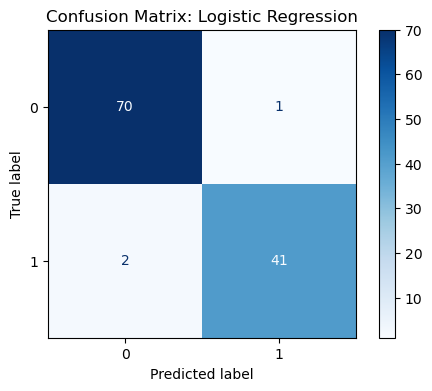

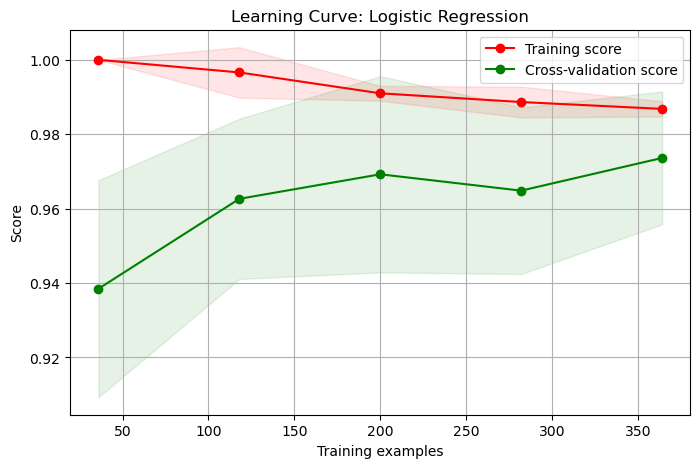

In [18]:
plot_metrics_visuals(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression")

# Model 2 - Decision Tree Classifier

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Initialize/Define the Model
dt_model = DecisionTreeClassifier(random_state=42)

In [20]:
dt_start_time = time.time()

In [21]:
# Train the Model
dt_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

In [22]:
dt_end_time = time.time()
dt_training_time = dt_end_time - dt_start_time
# --- Print Training Time ---
print(f"Decision Tree Classifier Training Time: {dt_training_time:.4f} seconds")

Decision Tree Classifier Training Time: 0.0293 seconds


In [23]:
# Predict
y_pred_dt = dt_model.predict(X_test_scaled)
y_prob_dt = dt_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate or Calculate Metrics
res_dt = evaluate_model("Decision Tree", y_test, y_pred_dt, y_prob_dt)
results.append(res_dt)

--- Results for Decision Tree ---
Accuracy : 0.9474
AUC Score: 0.9440
Precision: 0.9474
Recall   : 0.9474
F1 Score : 0.9474
MCC Score: 0.8880
------------------------------


Visualization for Decision Tree Classifier

--- Visualizing Decision Tree ---


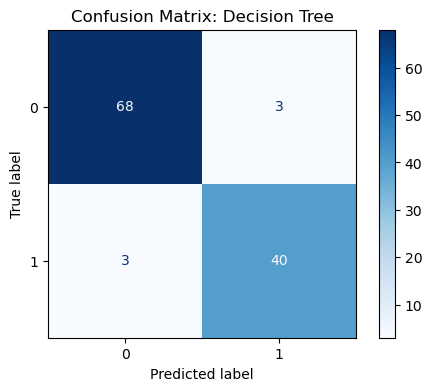

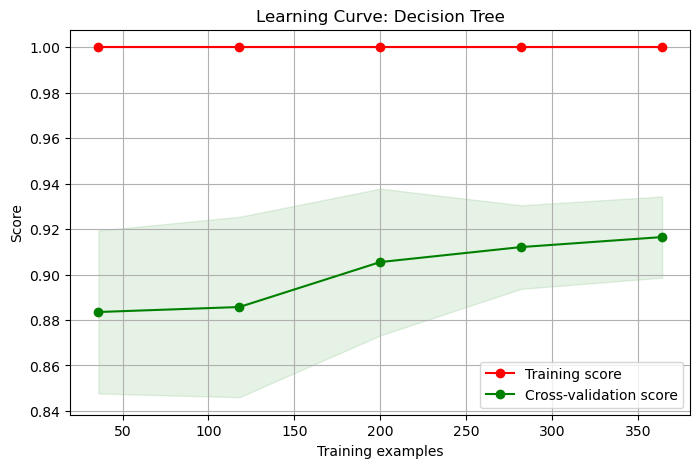

In [24]:
plot_metrics_visuals(dt_model, X_train_scaled, y_train, X_test_scaled, y_test, "Decision Tree")

# Model 3 - K-Nearest Neighbors (KNN)

In [25]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize/Define the Model
knn_model = KNeighborsClassifier(n_neighbors=5)

In [26]:
knn_start_time = time.time()

In [27]:
# Train the Model
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [28]:
knn_end_time = time.time()
knn_training_time = knn_end_time - knn_start_time
# --- Print Training Time ---
print(f"K-Nearest Neighbors Training Time: {knn_training_time:.4f} seconds")

K-Nearest Neighbors Training Time: 0.0309 seconds


In [29]:
# Predict
y_pred_knn = knn_model.predict(X_test_scaled)
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate or Calculate Metrics
res_knn = evaluate_model("KNN", y_test, y_pred_knn, y_prob_knn)
results.append(res_knn)

--- Results for KNN ---
Accuracy : 0.9474
AUC Score: 0.9820
Precision: 0.9474
Recall   : 0.9474
F1 Score : 0.9474
MCC Score: 0.8880
------------------------------


Visualization for K-Nearest Neighbors (KNN)

--- Visualizing KNN ---


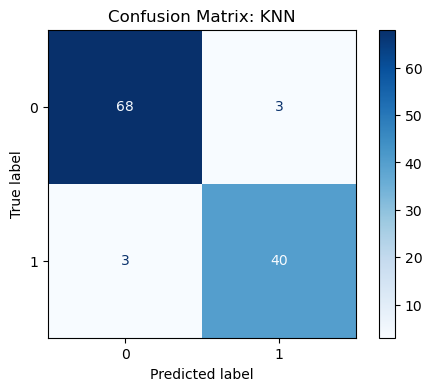

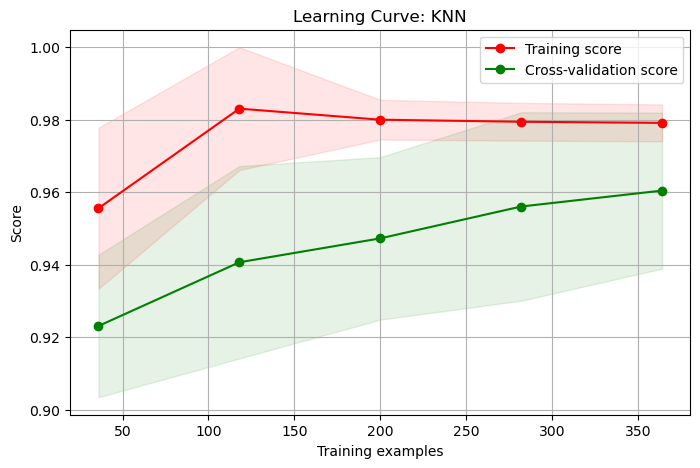

In [30]:
plot_metrics_visuals(knn_model, X_train_scaled, y_train, X_test_scaled, y_test, "KNN")

# Model 4 - Naive Bayes (Gaussian)

In [31]:
from sklearn.naive_bayes import GaussianNB

# Initialize/Define the Model
nb_model = GaussianNB()

In [32]:
nb_start_time = time.time()

In [33]:
# Train the Model
nb_model.fit(X_train_scaled, y_train)

GaussianNB()

In [34]:
nb_end_time = time.time()
nb_training_time = nb_end_time - nb_start_time
# --- Print Training Time ---
print(f"Naive Bayes Gaussian Training Time: {nb_training_time:.4f} seconds")

Naive Bayes Gaussian Training Time: 0.0221 seconds


In [35]:
# Predict
y_pred_nb = nb_model.predict(X_test_scaled)
y_prob_nb = nb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate or Calculate Metrics
res_nb = evaluate_model("Naive Bayes", y_test, y_pred_nb, y_prob_nb)
results.append(res_nb)

--- Results for Naive Bayes ---
Accuracy : 0.9649
AUC Score: 0.9974
Precision: 0.9652
Recall   : 0.9649
F1 Score : 0.9647
MCC Score: 0.9253
------------------------------


Visualization for Naive Bayes (Gaussian)

--- Visualizing Naive Bayes ---


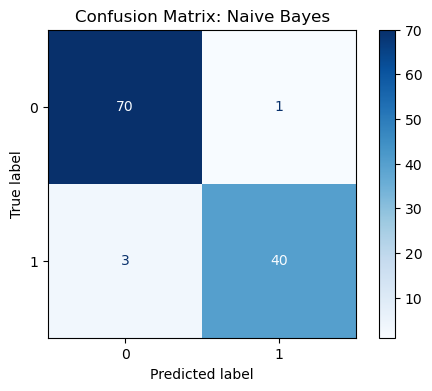

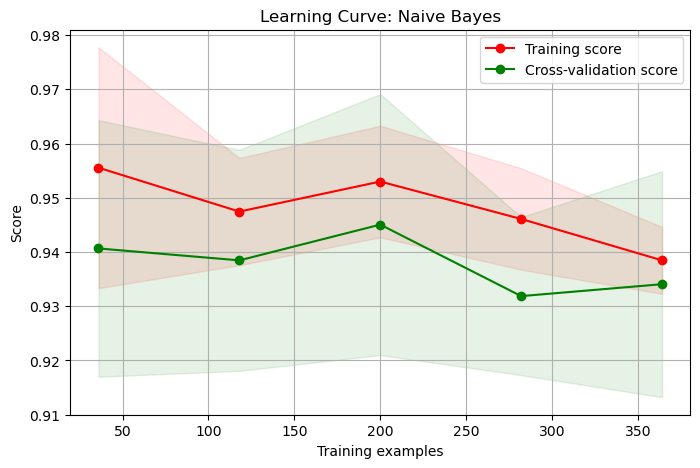

In [36]:
plot_metrics_visuals(nb_model, X_train_scaled, y_train, X_test_scaled, y_test, "Naive Bayes")

# Model 5 - Random Forest (Ensemble)

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Initialize/Define the Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [38]:
rf_start_time = time.time()

In [39]:
# Train the Model
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [40]:
rf_end_time = time.time()
rf_training_time = rf_end_time - rf_start_time
# --- Print Training Time ---
print(f"Random Forest Ensemble Training Time: {rf_training_time:.4f} seconds")

Random Forest Ensemble Training Time: 0.2250 seconds


In [41]:
# Predict
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate or Calculate Metrics
res_rf = evaluate_model("Random Forest", y_test, y_pred_rf, y_prob_rf)
results.append(res_rf)

--- Results for Random Forest ---
Accuracy : 0.9649
AUC Score: 0.9953
Precision: 0.9652
Recall   : 0.9649
F1 Score : 0.9647
MCC Score: 0.9253
------------------------------


Visualization for Random Forest (Ensemble)

--- Visualizing Random Forest ---


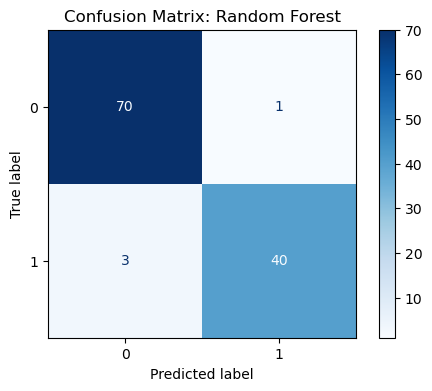

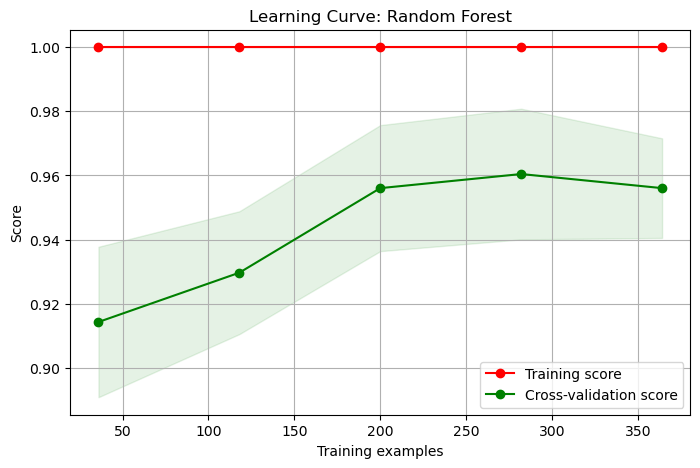

In [42]:
plot_metrics_visuals(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")

# Model 6 - XGBoost (Ensemble)

In [43]:
from xgboost import XGBClassifier

# Initialize/Define the Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [44]:
xgb_start_time = time.time()

In [45]:
# Train the Model
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [46]:
xgb_end_time = time.time()
xgb_training_time = xgb_end_time - xgb_start_time
# --- Print Training Time ---
print(f"XGBoost Ensemble Training Time: {xgb_training_time:.4f} seconds")

XGBoost Ensemble Training Time: 0.0810 seconds


In [47]:
# Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate or Calculate Metrics
res_xgb = evaluate_model("XGBoost", y_test, y_pred_xgb, y_prob_xgb)
results.append(res_xgb)

--- Results for XGBoost ---
Accuracy : 0.9561
AUC Score: 0.9908
Precision: 0.9561
Recall   : 0.9561
F1 Score : 0.9560
MCC Score: 0.9064
------------------------------


Visualization for XGBoost (Ensemble)

--- Visualizing XGBoost ---


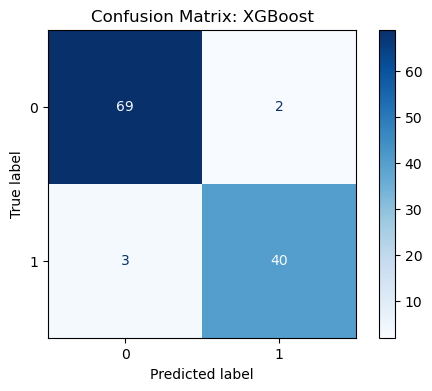

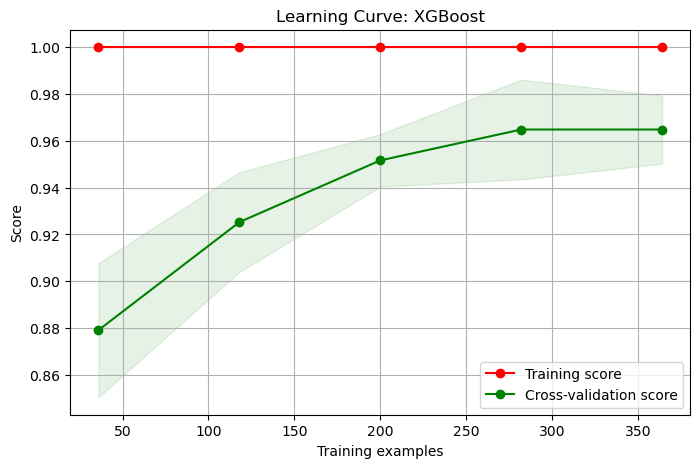

In [48]:
plot_metrics_visuals(xgb_model, X_train_scaled, y_train, X_test_scaled, y_test, "XGBoost")

# Model Performance Metrics Comparison Table

Final Model Comparison:


,ML Model Name,Accuracy,AUC,Precision,Recall,F1,MCC
0,Logistic Regression,0.9737,0.9974,0.9737,0.9737,0.9736,0.9439
1,Decision Tree,0.9474,0.9440,0.9474,0.9474,0.9474,0.8880
2,KNN,0.9474,0.9820,0.9474,0.9474,0.9474,0.8880
3,Naive Bayes,0.9649,0.9974,0.9652,0.9649,0.9647,0.9253
4,Random Forest,0.9649,0.9953,0.9652,0.9649,0.9647,0.9253
5,XGBoost,0.9561,0.9908,0.9561,0.9561,0.9560,0.9064


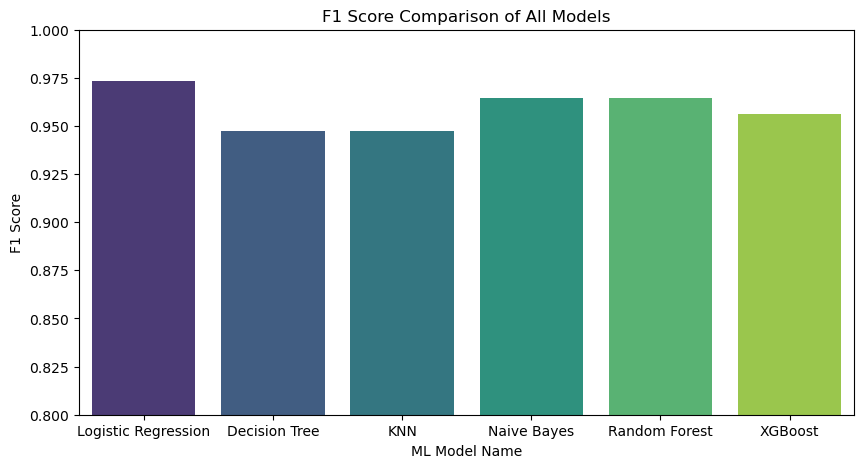

In [49]:
# Convert results list to DataFrame
final_df = pd.DataFrame(results)

# Display table
print("Final Model Comparison:")
display(final_df.round(4))

# Optional: Plot F1 Scores
plt.figure(figsize=(10, 5))
sns.barplot(x="ML Model Name", y="F1", data=final_df, palette="viridis")
plt.title("F1 Score Comparison of All Models")
plt.ylim(0.8, 1.0)
plt.ylabel("F1 Score")
plt.show()

# Training Time Comparision for All Models

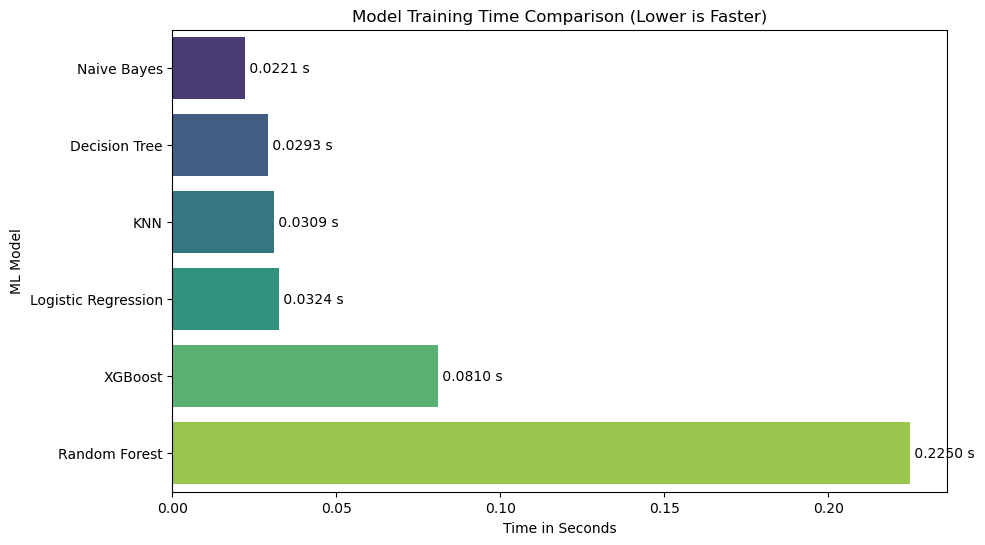


--- Training Time Comparison Table ---


,ML Model,Training Time (s)
3,Naive Bayes,0.022098
1,Decision Tree,0.029293
2,KNN,0.030922
0,Logistic Regression,0.032383
5,XGBoost,0.080964
4,Random Forest,0.225038


In [50]:
# --- Training Time Comparison ---

# 1. Collect the times from your specific variables
# Ensure all these variables are defined by running the training cells above
models_time_data = {
    "Logistic Regression": lr_training_time,
    "Decision Tree": dt_training_time,
    "KNN": knn_training_time,
    "Naive Bayes": nb_training_time,
    "Random Forest": rf_training_time,
    "XGBoost": xgb_training_time
}

# 2. Convert to DataFrame
time_df = pd.DataFrame(list(models_time_data.items()), columns=['ML Model', 'Training Time (s)'])

# 3. Sort for better visualization
time_df = time_df.sort_values(by='Training Time (s)', ascending=True)

# 4. Visualize
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Training Time (s)", y="ML Model", data=time_df, palette="viridis")

# Add value labels to the bars
for i, v in enumerate(time_df['Training Time (s)']):
    barplot.text(v, i, f" {v:.4f} s", color='black', va='center')

plt.title("Model Training Time Comparison (Lower is Faster)")
plt.xlabel("Time in Seconds")
plt.show()

# 5. Print the Table
print("\n--- Training Time Comparison Table ---")
display(time_df)